In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from tensorflow.keras.layers import Dense, Dropout

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

#### Defining main functions 

In [2]:
def mean_absolute_percentage_error_func(y_true, y_pred):
    '''
    Calculate the mean absolute percentage error as a metric for evaluation
    '''    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [4]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
        
    print('Metric Results: ')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred).round(2)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred).round(2)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred)).round(2)}')
    print(f'MAPE is : {mean_absolute_percentage_error_func(y_true, y_pred).round(2)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred).round()}',end='\n\n')

#### Reading Data-Set

In [5]:
df = pd.read_csv('lstmdataset.csv',index_col='Date',parse_dates=True)
df.index.freq='MS'

In [6]:
df

,Orders,PPI_ConcreteProducts_lag3,PPI_ConstructionMaterials_lag3,All_EmployeesConstruction_lag3,HomesUSA_lag3,UnemploymentRate_lag3,JobOpenConstruction_lag3
Date,,,,,,,
2018-01-01,1.266171,258.500,333.769,7093,103,3.7,390
2018-02-01,-0.617705,259.200,330.548,7184,98,3.6,331
2018-03-01,0.882906,263.900,326.320,7194,95,3.5,413
2018-04-01,0.693607,262.300,225.800,7212,103,4.0,255
2018-05-01,1.323791,264.200,228.700,7274,102,4.1,212
...,...,...,...,...,...,...,...
2022-11-01,-1.321594,347.344,342.753,7833,116,3.7,386
2022-12-01,-1.747332,350.787,336.464,7859,110,3.5,423
2023-01-01,-1.249637,343.900,333.769,7814,103,3.7,390


### Transforming all variables 

In [7]:
#Remove Increasing Volatility
orders_series = df.Orders
annual_volatility = orders_series.groupby(orders_series.index.year).std()
orders_annual_vol = orders_series.index.map(lambda d: annual_volatility.loc[d.year])
orders_series = orders_series / orders_annual_vol

#Remove Seasonality
month_avgs = orders_series.groupby(orders_series.index.month).mean()
orders_month_avg = orders_series.index.map(lambda d: month_avgs.loc[d.month])
orders_series = orders_series - orders_month_avg


In [8]:
#Remove Increasing Volatility
Concrete_series = df.PPI_ConcreteProducts_lag3
Concrete_annual_volatility = Concrete_series.groupby(Concrete_series.index.year).std()
Concrete_annual_vol = Concrete_series.index.map(lambda d: Concrete_annual_volatility.loc[d.year])
Concrete_series = Concrete_series / Concrete_annual_vol

#Remove Seasonality
month_avgs1 = Concrete_series.groupby(Concrete_series.index.month).mean()
Concrete_month_avg = Concrete_series.index.map(lambda d: month_avgs1.loc[d.month])
Concrete_series = Concrete_series - Concrete_month_avg

In [9]:
#Remove Increasing Volatility
Construction_series = df.PPI_ConstructionMaterials_lag3
Construction_annual_volatility = Construction_series.groupby(Construction_series.index.year).std()
Construction_annual_vol = Construction_series.index.map(lambda d: Construction_annual_volatility.loc[d.year])
Construction_series = Construction_series / Construction_annual_vol

#Remove Seasonality
month_avgs2 = Construction_series.groupby(Construction_series.index.month).mean()
Construction_month_avg = Construction_series.index.map(lambda d: month_avgs2.loc[d.month])
Construction_series = Construction_series - Construction_month_avg

In [10]:
#Remove Increasing Volatility
Employees_series = df.All_EmployeesConstruction_lag3
Employees_annual_volatility = Employees_series.groupby(Employees_series.index.year).std()
Employees_annual_vol = Employees_series.index.map(lambda d: Employees_annual_volatility.loc[d.year])
Employees_series = Employees_series / Employees_annual_vol

#Remove Seasonality
month_avgs3 = Employees_series.groupby(Employees_series.index.month).mean()
Employees_month_avg = Employees_series.index.map(lambda d: month_avgs3.loc[d.month])
Employees_series = Employees_series - Employees_month_avg

In [11]:
#Remove Increasing Volatility
HomesUSA_series = df.HomesUSA_lag3  
HomesUSA_annual_volatility = HomesUSA_series.groupby(HomesUSA_series.index.year).std()
HomesUSA_annual_vol = HomesUSA_series.index.map(lambda d: HomesUSA_annual_volatility.loc[d.year])
HomesUSA_series = HomesUSA_series  / HomesUSA_annual_vol

#Remove Seasonality
month_avgs4 = HomesUSA_series.groupby(HomesUSA_series.index.month).mean()
HomesUSA__month_avg = HomesUSA_series.index.map(lambda d: month_avgs4.loc[d.month])
HomesUSA_series = HomesUSA_series - HomesUSA__month_avg

In [12]:
#Remove Increasing Volatility
Unemployment_series = df.UnemploymentRate_lag3
Unemploymen_annual_volatility = Unemployment_series.groupby(Unemployment_series.index.year).std()
Unemploymen_annual_vol = Unemployment_series.index.map(lambda d: Unemploymen_annual_volatility.loc[d.year])
Unemploymen_series = Unemployment_series / Unemploymen_annual_vol 

#Remove Seasonality
month_avgs5 = Unemploymen_series.groupby(Unemploymen_series.index.month).mean()
Unemploymen_month_avg = Unemploymen_series.index.map(lambda d: month_avgs5.loc[d.month])
Unemploymen_series = Unemploymen_series - Unemploymen_month_avg

In [13]:
#Remove Increasing Volatility
JobOpen_series = df.JobOpenConstruction_lag3
JobOpen_annual_volatility = JobOpen_series.groupby(JobOpen_series.index.year).std()
JobOpen_annual_vol = JobOpen_series.index.map(lambda d: JobOpen_annual_volatility.loc[d.year])
JobOpen_series = JobOpen_series / JobOpen_annual_vol

#Remove Seasonality
month_avgs6 = JobOpen_series.groupby(JobOpen_series.index.month).mean()
JobOpen_month_avg = JobOpen_series.index.map(lambda d: month_avgs6.loc[d.month])
JobOpen_series = JobOpen_series - JobOpen_month_avg

### Replacing the Transforming Data into a Dataframe

In [14]:
df['Orders'] = orders_series
df['PPI_ConcreteProducts_lag3'] = Concrete_series
df['PPI_ConstructionMaterials_lag3'] = Construction_series
df['All_EmployeesConstruction_lag3'] = Employees_series
df['HomesUSA_lag3'] = HomesUSA_series
df['UnemploymentRate_lag3'] = Unemploymen_series 
df['JobOpenConstruction_lag3'] = JobOpen_series

In [15]:
#Variables for training
cols = list(df)[0:8]
print(cols) 

['Orders', 'PPI_ConcreteProducts_lag3', 'PPI_ConstructionMaterials_lag3', 'All_EmployeesConstruction_lag3', 'HomesUSA_lag3', 'UnemploymentRate_lag3', 'JobOpenConstruction_lag3']


In [16]:
df_for_training = df[cols].astype(float)

### Normalize the data using the StandardScaler

In [17]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

###  Create sequences of data for the LSTM model

In [18]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1  
n_past = 12  

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (51, 12, 7).
trainY shape == (51, 1).


### Define and compile the LSTM model

In [19]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 100)           43200     
                                                                 
 lstm_1 (LSTM)               (None, 32)                17024     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 60,257
Trainable params: 60,257
Non-trainable params: 0
_________________________________________________________________


### Fit the model

In [20]:
history = model.fit(trainX, trainY, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/100
3/3 [==============================] - 2s 211ms/step - loss: 0.5739 - val_loss: 4.0759
Epoch 2/100
3/3 [==============================] - 0s 23ms/step - loss: 0.4740 - val_loss: 3.7336
Epoch 3/100
3/3 [==============================] - 0s 22ms/step - loss: 0.4182 - val_loss: 3.2994
Epoch 4/100
3/3 [==============================] - 0s 21ms/step - loss: 0.3394 - val_loss: 2.7062
Epoch 5/100
3/3 [==============================] - 0s 20ms/step - loss: 0.2795 - val_loss: 1.8849
Epoch 6/100
3/3 [==============================] - 0s 22ms/step - loss: 0.2315 - val_loss: 0.9363
Epoch 7/100
3/3 [==============================] - 0s 22ms/step - loss: 0.2123 - val_loss: 0.7378
Epoch 8/100
3/3 [==============================] - 0s 22ms/step - loss: 0.2211 - val_loss: 1.2749
Epoch 9/100
3/3 [==============================] - 0s 23ms/step - loss: 0.2091 - val_loss: 1.0783
Epoch 10/100
3/3 [==============================] - 0s 22ms/step - loss: 0.1747 - val_loss: 0.5974
Epoch 11/100
3/3 [

Epoch 84/100
3/3 [==============================] - 0s 20ms/step - loss: 0.1224 - val_loss: 0.8476
Epoch 85/100
3/3 [==============================] - 0s 19ms/step - loss: 0.1108 - val_loss: 0.8875
Epoch 86/100
3/3 [==============================] - 0s 20ms/step - loss: 0.1176 - val_loss: 0.9655
Epoch 87/100
3/3 [==============================] - 0s 20ms/step - loss: 0.1391 - val_loss: 0.8587
Epoch 88/100
3/3 [==============================] - 0s 20ms/step - loss: 0.1297 - val_loss: 0.7803
Epoch 89/100
3/3 [==============================] - 0s 20ms/step - loss: 0.1123 - val_loss: 0.8459
Epoch 90/100
3/3 [==============================] - 0s 20ms/step - loss: 0.1009 - val_loss: 0.8108
Epoch 91/100
3/3 [==============================] - 0s 19ms/step - loss: 0.1212 - val_loss: 0.9145
Epoch 92/100
3/3 [==============================] - 0s 20ms/step - loss: 0.1203 - val_loss: 0.9612
Epoch 93/100
3/3 [==============================] - 0s 20ms/step - loss: 0.1270 - val_loss: 0.8744
Epoch 94/1

### Plot the Trainig and Validation Loss

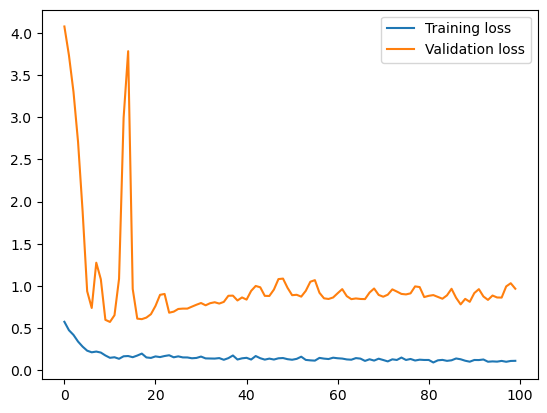

In [21]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

### Make Prediction

In [22]:
n_months_for_prediction=15 
prediction = model.predict(trainX[-n_months_for_prediction:])

1/1 [==============================] - 0s 259ms/step


In [23]:
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [24]:
y_pred_future

array([-0.45905942, -0.6796175 , -1.0074384 , -1.575701  , -1.9051237 ,
       -2.1120224 , -2.2237034 , -2.3569536 , -2.580905  , -2.6609051 ,
       -2.8521454 , -3.0210574 , -3.059438  , -2.6445093 , -2.2178214 ],
      dtype=float32)

In [25]:
df_test = df_for_training[48:]

### Inverse transform the predicted values to get them back to their original scale

In [26]:
df_forecast = pd.DataFrame({'Date':df_test.index, 'Orders': df_test['Orders'], 'Orders_Predicted':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])
df_forecast = df_forecast.reset_index(drop=True)
df_forecast.set_index('Date', inplace=True)

In [27]:
df_forecast

,Orders,Orders_Predicted
Date,,
2022-01-01,-0.239672,-0.459059
2022-02-01,-1.385019,-0.679618
2022-03-01,0.322190,-1.007438
2022-04-01,-2.456404,-1.575701
2022-05-01,-2.613226,-1.905124
2022-06-01,-1.928286,-2.112022
2022-07-01,-2.824245,-2.223703
2022-08-01,-2.472453,-2.356954
2022-09-01,-2.866090,-2.580905


In [33]:
df_forecast['Orders_Predicted'].tail(3)

Date
2023-01-01   -3.059438
2023-02-01   -2.644509
2023-03-01   -2.217821
Name: Orders_Predicted, dtype: float32

In [28]:
df_forecast1 = df_forecast[:12]
df_future = df_forecast[-3:]
train = df_for_training[:60]
df_test1 = df_test[:12]

In [29]:
y_test = df_forecast['Orders'].to_numpy()

### Plot Results

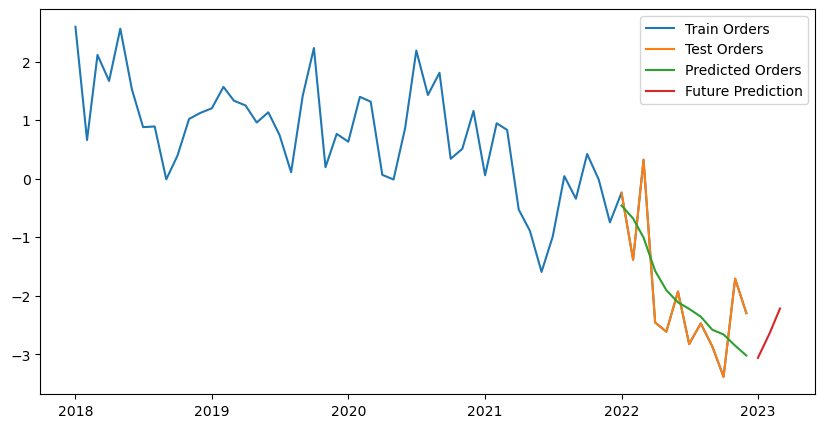

In [30]:
plt.rcParams["figure.figsize"] = [10,5]
plt.plot(train['Orders'], label='Train Orders')
plt.plot(df_test1['Orders'], label='Test Orders')
plt.plot(df_forecast1['Orders_Predicted'], label='Predicted Orders')
plt.plot(df_future['Orders_Predicted'], label='Future Prediction')
plt.legend(loc='best')
plt.show()

### Evaluate the Model

In [57]:
timeseries_evaluation_metrics_func(y_test, y_pred_future)

Metric Results: 
MSE is : 0.99
MAE is : 0.72
RMSE is : 0.99
MAPE is : 50.45
R2 is : 1.0

